<hr/>

# imports

In [48]:
!pip install imblearn


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [49]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # mute tf warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import tensorflow as tf
from tensorflow import keras
from transformers import BertTokenizer, TFBertModel
import math
import sklearn
import imblearn

In [50]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Definitions

In [51]:
def pipe(*funcs):
    """
    Works similar to the semantics of a `pipe` in other programming languages.
    Intended to make nested functions readable and easier to manipulate. It 
    will take the first item in the list and feed it as input to the next
    function in the list, then it takes that output and feeds it as input to 
    the next function in the list, and so on until it reaches the last
    function in the list and returns its output.

    Example:
        instead of this:
            ```py
            input_layer = Input(...)
            embedding_layer = Embedding(...)(input_layer)
            lstm_layer = LSTM(...)(embedding_layer)
            hidden_layer = Dense(...)(lstm_layer)
            output_layer = Dense(...)(hidden_layer)
            ```
        you can do this:
            ```py
            lstm_ouput = pipe(
                Input(...),
                Embedding(...),
                LSTM(...),
                Dense(...),
                Dense(...)
            )
            ```
    """
    out = funcs[0]
    for func in funcs[1:]:
        out = func(out)
    return out

In [52]:
def determine_name(row) -> str:
    """
    Auxilary function used to determine the label for each given row.
    """
    if row['sender_labels'] and row['receiver_labels']:
        return 'straightforward'
    elif not row['sender_labels'] and row['receiver_labels']:
        return 'deceive'
    elif row['sender_labels'] and not row['receiver_labels']:
        return 'cassandra'
    elif not row['sender_labels'] and not row['receiver_labels']:
        return 'caught'
    else:
        return None

In [53]:
def parse_jsonl(path: str) -> pd.DataFrame:
    """
    Load the given jsonl file and parse each conversation into a readable pandas
    data frame, where each row is a message. Additional data that is used later
    is also added to the created dataframe for consistency accross all loaded
    data.

    Args:
        path: str
            the path to the jsonl file to load and parse
    
    Returns: pd.DataFrame
        A parsed data frame where each row is a message.
    """
    data = {}
    with open(path, 'r') as f:
        for (i, line) in enumerate(f):
            line = json.loads(line)
            line["conversation_id"] = [i] * len(line["messages"])
            line['previous_message'] = ([""] if len(line['messages']) > 0 else []) + line["messages"][:-1]
            for k in line.keys():
                if k == "players":
                    continue
                if k == "game_id":
                    line[k] = [line[k]] * len(line["messages"])
                data[k] = data.get(k, []) + line[k]
    data = pd.DataFrame(data)
    data['label'] = data.apply(determine_name, axis=1)
    data['sender_labels_encoded'] = data['sender_labels'].astype(str).apply(lambda x: ["True", "False", "NOANNOTATION"].index(x))
    data['receiver_labels_encoded'] = data['receiver_labels'].astype(str).apply(lambda x: ["True", "False", "NOANNOTATION"].index(x))
    data["game_score_delta"] = data['game_score_delta'].astype(float)
    return data

In [122]:
def EvaluateModel(model: tf.keras.Sequential, test_ds: tf.data.Dataset, test_target: pd.DataFrame, history: tf.keras.callbacks.History, skip_evaluation: bool = False) -> None:
    """
    Take the model and plot the training accuracy and validation accuracy. Also,
    Perform a evaluation on the test data, print the loss and accuracy, and print
    the test metric scores.

    Args:
        model: tf.keras.Sequential
            the model to test
        test_ds: tf.data.Dataset
            the test dataset to evaluate the model with
        test_target: pd.DataFrame
            the test data frame list with the target labels
        history: tf.keras.callbacks.History
            the history from fitting the model
        label_encoder:
            the label encoder used for the target labels
    """

    print(f"{'='*10} Model Accuracy {'='*10}")
    plt.plot(history.history['sender_output_accuracy'], label='sender_output_accuracy', color="tan")
    plt.plot(history.history['val_sender_output_accuracy'], label = 'val_sender_output_accuracy', color="darkorange")
    plt.plot(history.history['receiver_output_accuracy'], label='receiver_output_accuracy', color="cornflowerblue")
    plt.plot(history.history['val_receiver_output_accuracy'], label = 'val_receiver_output_accuracy', color="darkblue")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.show()

    if not skip_evaluation:
        print(f"{'='*10} Test Evaluation {'='*10}")
        model.evaluate(test_ds, test_target, verbose=2)
        # print(f"Test loss: {test_loss} | Test accuracy: {test_acc}")
        print()

    print(f"{'='*10} Test Metrics {'='*10}")
    y_pred = model.predict(test_ds)
    print(f"{'-'*10} Sender Labels {'-'*10}")
    print(sklearn.metrics.classification_report(test_target[0], np.argmax(y_pred[0], axis=1), target_names=["True", "False"], zero_division=0))
    print(f"{'-'*10} Receiver Labels {'-'*10}")
    print(sklearn.metrics.classification_report(test_target[1], np.argmax(y_pred[1], axis=1), target_names=["True", "False", "NOANNOTATION"], zero_division=0))

In [55]:
def Tokenize(tokenizer, df: pd.DataFrame, sequence_len: int = 300) -> tuple:
    """
    Makes a consistant return of tokenized and padded messages and previous messages.
    """
    encoded_msg = tokenizer.texts_to_sequences(df['messages'])
    encoded_prev_msg = tokenizer.texts_to_sequences(df['previous_message'])
    return keras.preprocessing.sequence.pad_sequences(encoded_msg, sequence_len), keras.preprocessing.sequence.pad_sequences(encoded_prev_msg, sequence_len)

<hr/>

# data explortion

In [56]:
train_df = pd.read_json("./data/train.jsonl", lines=True)
train_df.head()

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,players,game_id
0,[Germany!\n\nJust the person I want to speak w...,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, NOANNOTATION, NOANNOT...","[italy, germany, italy, germany, italy, italy,...","[germany, italy, germany, italy, germany, germ...","[74, 76, 86, 87, 89, 92, 97, 117, 119, 121, 12...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, germany]",1
1,[Hello there! What's your general plan for thi...,"[True, False, True, False, True, True, True, T...","[True, True, True, True, True, NOANNOTATION, T...","[austria, italy, austria, italy, italy, austri...","[italy, austria, italy, austria, austria, ital...","[1, 67, 71, 73, 98, 99, 101, 179, 181, 185, 18...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 4, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, -1, -...","[italy, austria]",1
2,[Buongiorno! \nBe kinda nice to know if you're...,"[True, True, False, True, True, True, True, Tr...","[True, False, True, False, True, True, NOANNOT...","[russia, italy, russia, italy, russia, italy, ...","[italy, russia, italy, russia, italy, russia, ...","[11, 50, 52, 57, 61, 66, 77, 85, 96, 102, 116,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[4, 3, 4, 3, 4, 3, 4, 3, 3, 3, 4, 3, 3, 4, 4, ...","[1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1...","[italy, russia]",1
3,[Hey italy! good luck this game. I'm guessing ...,"[True, False, True, True, True, True, True, Tr...","[NOANNOTATION, True, True, False, True, True, ...","[england, italy, england, england, england, it...","[italy, england, italy, italy, italy, england,...","[32, 95, 106, 107, 108, 110, 113, 125, 126, 12...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, england]",1
4,[Hello Italy what’s up what are your thoughts ...,"[True, False, False, True, True, True, True, T...","[NOANNOTATION, True, True, True, True, True, N...","[turkey, italy, italy, italy, turkey, italy, t...","[italy, turkey, turkey, turkey, italy, turkey,...","[45, 94, 103, 150, 154, 178, 192, 194, 195, 19...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Fall, Fall, F...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 5, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 1...","[italy, turkey]",1


just a raw load of the data we can see it is unformated and needs to be parsed a little to better satisfy the pandas format.

In [57]:
train_df = (parse_jsonl("./data/train.jsonl"))
test_df = (parse_jsonl("./data/test.jsonl"))
validation_df = (parse_jsonl("./data/validation.jsonl"))

In [58]:
train_df.head()

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,game_id,conversation_id,previous_message,label,sender_labels_encoded,receiver_labels_encoded
0,Germany!\n\nJust the person I want to speak wi...,True,True,italy,germany,74,0,Spring,1901,3,0.0,1,0,,straightforward,0,0
1,"You've whet my appetite, Italy. What's the sug...",True,True,germany,italy,76,1,Spring,1901,3,0.0,1,0,Germany!\n\nJust the person I want to speak wi...,straightforward,0,0
2,👍,True,True,italy,germany,86,2,Spring,1901,3,0.0,1,0,"You've whet my appetite, Italy. What's the sug...",straightforward,0,0
3,It seems like there are a lot of ways that cou...,True,True,germany,italy,87,3,Spring,1901,3,0.0,1,0,👍,straightforward,0,0
4,"Yeah, I can’t say I’ve tried it and it works, ...",True,NOANNOTATION,italy,germany,89,4,Spring,1901,3,0.0,1,0,It seems like there are a lot of ways that cou...,straightforward,0,2


# NONANNOTATION

We can see that there are some `receiver_labels` that have the value `NOANNOTATION`. this is not a bool value 

In [59]:
round(len(train_df[train_df["receiver_labels"] == "NOANNOTATION"].index) /  len(train_df.index), 4) * 100

8.43

I think we can ignore this for now since the main columns i think we will be using are `messages` and `sender_labels`

If we do need it in the future, we can omit it only losing 8.43% of the rows.

# Unique Words

In [60]:
sequence_list = list(train_df['messages'].astype(str).str.lower().str.split().to_numpy())
unique_words = {}
for sequence in sequence_list:
    for word in sequence:
        unique_words[word] = unique_words.get(word, 0) + 1
    # sequence_list = sequence_list + (["<PAD>"] )

for (i,(k,v)) in enumerate(unique_words.items()):
    if i > 30:
        break
    print(f"{k}: {v}")

germany!: 12
just: 1250
the: 6574
person: 29
i: 8947
want: 842
to: 11615
speak: 18
with.: 34
have: 2087
a: 4783
somewhat: 16
crazy: 16
idea: 97
that: 3692
i’ve: 153
always: 84
wanted: 146
try: 307
with: 2567
i/g,: 1
but: 2250
never: 109
actually: 208
convinced: 11
other: 285
guy: 30
it.: 263
and,: 38
what’s: 85
worse,: 3


In [61]:
len(unique_words)

15657

<!-- I processed only what is considered a **word** to the regex `\w+`. this means that any punctuation is omitted. -->

After processing, we have a total of 15,657 words.

Some things to note are
- there are some arbitrary number included
- some words are repeated because of long character exaggeration (for example, "aaaaaalllllllllll" instead of "all" or "aaaaany" instead of "any")
- some words are repeated because of misspellings and typos

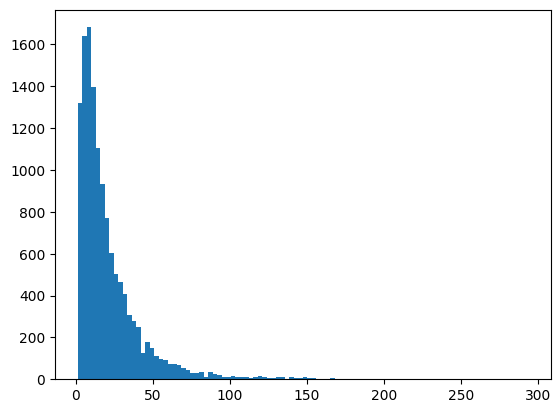

In [62]:
plt.hist(list(map(len, sequence_list)),bins=100)
plt.show()

In [63]:
summary = {
    "": [
        'Message count',
        'Average words per message',
        'Unique word count',
        'Actual Lie count',
        'Actual Truth count'
    ],
    "value": [
        len(train_df.index),
        math.floor(sum(map(len, sequence_list)) / len(sequence_list)),
        len(unique_words),
        (~train_df['sender_labels']).sum(),
        (train_df['sender_labels']).sum()
    ],
}
pd.DataFrame(summary)

,,value
0,Message count,13132
1,Average words per message,20
2,Unique word count,15657
3,Actual Lie count,591
4,Actual Truth count,12541


# Label count

In [64]:
train_df['label'].value_counts()

label
straightforward    12040
deceive              526
cassandra            501
caught                65
Name: count, dtype: int64

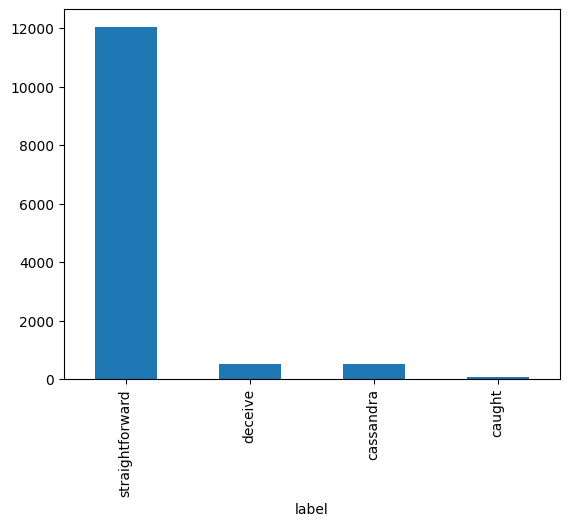

In [65]:
train_df['label'].value_counts().plot.bar()
plt.show()

In [66]:
train_df['label'].value_counts(normalize=True)

label
straightforward    0.916844
deceive            0.040055
cassandra          0.038151
caught             0.004950
Name: proportion, dtype: float64

<hr/>

# Constants

In [67]:
MAX_SEQUENCE_LEN = max(map(len,sequence_list))
VOCAB_SIZE = 5000 # len(unique_words)
EMBEDDING_OUTPUT_SIZE = 124
LSTM_SIZE = 64
DROPOUT_RATE = 0.2
HIDDEN_LAYER_SIZE = 64
LEARNING_RATE = 0.001

tokenizer = keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['messages'])
smote = imblearn.over_sampling.SMOTE()

# train_encoded_padded, y_train = smote.fit_resample(train_tokenized_padded, train_df['label_encoded'])
# train_prev_encoded_padded, y_train = smote.fit_resample(train_prev_tokenized_padded, train_df['label_encoded'])

train_encoded_padded, train_prev_encoded_padded = Tokenize(tokenizer, train_df, MAX_SEQUENCE_LEN)
test_encoded_padded, test_prev_encoded_padded = Tokenize(tokenizer, test_df, MAX_SEQUENCE_LEN)
validation_encoded_padded, validation_prev_encoded_padded = Tokenize(tokenizer, validation_df, MAX_SEQUENCE_LEN)

<hr/>

# Naive Neural Network

In [124]:
def create_naive_model(
        vocab_size: int = VOCAB_SIZE,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        sequence_length: int = MAX_SEQUENCE_LEN,
        hidden_size: int = HIDDEN_LAYER_SIZE,
        learning_rate: float = LEARNING_RATE
    ):

    message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='message_input')
    
    naive_output = pipe(
        message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.Flatten(),
        keras.layers.Dense(hidden_size, activation="relu")
    )
        
    sender_output = keras.layers.Dense(2, activation='softmax', name="sender_output")(naive_output)
    receiver_output = keras.layers.Dense(3, activation='softmax', name="receiver_output")(naive_output)

    model = keras.Model(
        inputs=[message_input],
        outputs=[sender_output, receiver_output]
    )

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )

    return model

In [125]:
naive_model = create_naive_model()
naive_model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 message_input (InputLayer)  [(None, 294)]                0         []                            
                                                                                                  
 embedding_12 (Embedding)    (None, 294, 124)             620000    ['message_input[0][0]']       
                                                                                                  
 flatten_10 (Flatten)        (None, 36456)                0         ['embedding_12[0][0]']        
                                                                                                  
 dense_11 (Dense)            (None, 64)                   2333248   ['flatten_10[0][0]']          
                                                                                           

In [126]:
naive_history = naive_model.fit(
    train_encoded_padded,
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=(validation_encoded_padded, [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]),
    epochs=10
)

Epoch 1/10
411/411 [==============================] - 18s 41ms/step - loss: 0.6646 - sender_output_loss: 0.1868 - receiver_output_loss: 0.4778 - sender_output_accuracy: 0.9548 - receiver_output_accuracy: 0.8724 - val_loss: 0.6214 - val_sender_output_loss: 0.1624 - val_receiver_output_loss: 0.4590 - val_sender_output_accuracy: 0.9605 - val_receiver_output_accuracy: 0.8729
Epoch 2/10
411/411 [==============================] - 6s 15ms/step - loss: 0.5249 - sender_output_loss: 0.1398 - receiver_output_loss: 0.3851 - sender_output_accuracy: 0.9577 - receiver_output_accuracy: 0.8770 - val_loss: 0.6855 - val_sender_output_loss: 0.1789 - val_receiver_output_loss: 0.5066 - val_sender_output_accuracy: 0.9605 - val_receiver_output_accuracy: 0.8701
Epoch 3/10
411/411 [==============================] - 5s 11ms/step - loss: 0.2914 - sender_output_loss: 0.0753 - receiver_output_loss: 0.2161 - sender_output_accuracy: 0.9765 - receiver_output_accuracy: 0.9261 - val_loss: 0.8540 - val_sender_output_loss

========== Model Accuracy ==========


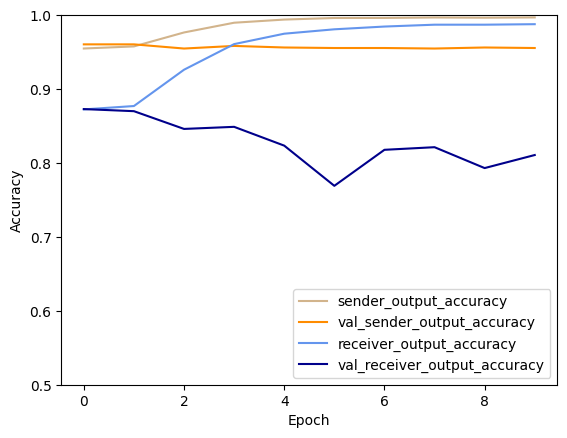

========== Test Evaluation ==========
86/86 - 1s - loss: 2.7263 - sender_output_loss: 1.0386 - receiver_output_loss: 1.6877 - sender_output_accuracy: 0.9044 - receiver_output_accuracy: 0.7906 - 583ms/epoch - 7ms/step

========== Test Metrics ==========
86/86 [==============================] - 0s 2ms/step
---------- Sender Labels ----------
              precision    recall  f1-score   support

        True       0.91      0.99      0.95      2501
       False       0.11      0.01      0.02       240

    accuracy                           0.90      2741
   macro avg       0.51      0.50      0.49      2741
weighted avg       0.84      0.90      0.87      2741

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True       0.84      0.93      0.88      2310
       False       0.12      0.04      0.06       165
NOANNOTATION       0.06      0.03      0.04       266

    accuracy                           0.79      2741
   macro avg       0.

In [127]:
EvaluateModel(naive_model, test_encoded_padded, [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']], naive_history)

# Naive LSTM

In [129]:
def create_naive_lstm_model(
        sequence_length: int = MAX_SEQUENCE_LEN,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        vocab_size: int = VOCAB_SIZE,
        lstm_size: int = LSTM_SIZE,
        hidden_size = HIDDEN_LAYER_SIZE,
        learning_rate: float = LEARNING_RATE,
    ):

    message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='message_input')

    naive_lstm_ouput = pipe(
        message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.LSTM(lstm_size),
        keras.layers.Dense(hidden_size),
    )

    sender_output = keras.layers.Dense(2, activation='softmax', name="sender_output")(naive_lstm_ouput)
    receiver_output = keras.layers.Dense(3, activation='softmax', name="receiver_output")(naive_lstm_ouput)

    model = keras.Model(
        inputs=[message_input],
        outputs=[sender_output, receiver_output]
    )

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )

    return model

In [130]:
naive_lstm_model = create_naive_lstm_model()
naive_lstm_model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 message_input (InputLayer)  [(None, 294)]                0         []                            
                                                                                                  
 embedding_13 (Embedding)    (None, 294, 124)             620000    ['message_input[0][0]']       
                                                                                                  
 lstm (LSTM)                 (None, 64)                   48384     ['embedding_13[0][0]']        
                                                                                                  
 dense_12 (Dense)            (None, 64)                   4160      ['lstm[0][0]']                
                                                                                           

In [131]:
naive_lstm_history = naive_lstm_model.fit(
    train_encoded_padded,
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=(validation_encoded_padded, [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]),
    epochs=10
)

Epoch 1/10
411/411 [==============================] - 27s 59ms/step - loss: 0.6774 - sender_output_loss: 0.1932 - receiver_output_loss: 0.4842 - sender_output_accuracy: 0.9543 - receiver_output_accuracy: 0.8699 - val_loss: 0.6433 - val_sender_output_loss: 0.1701 - val_receiver_output_loss: 0.4732 - val_sender_output_accuracy: 0.9605 - val_receiver_output_accuracy: 0.8729
Epoch 2/10
411/411 [==============================] - 13s 33ms/step - loss: 0.6109 - sender_output_loss: 0.1645 - receiver_output_loss: 0.4464 - sender_output_accuracy: 0.9552 - receiver_output_accuracy: 0.8724 - val_loss: 0.6410 - val_sender_output_loss: 0.1718 - val_receiver_output_loss: 0.4693 - val_sender_output_accuracy: 0.9605 - val_receiver_output_accuracy: 0.8729
Epoch 3/10
411/411 [==============================] - 13s 33ms/step - loss: 0.5252 - sender_output_loss: 0.1345 - receiver_output_loss: 0.3907 - sender_output_accuracy: 0.9572 - receiver_output_accuracy: 0.8744 - val_loss: 0.7101 - val_sender_output_lo

========== Model Accuracy ==========


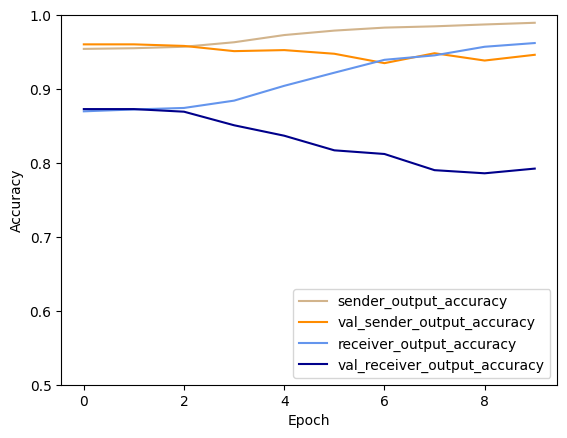

========== Test Evaluation ==========
86/86 - 1s - loss: 2.3568 - sender_output_loss: 0.8793 - receiver_output_loss: 1.4775 - sender_output_accuracy: 0.8960 - receiver_output_accuracy: 0.7632 - 1s/epoch - 14ms/step

========== Test Metrics ==========
86/86 [==============================] - 1s 12ms/step
---------- Sender Labels ----------
              precision    recall  f1-score   support

        True       0.92      0.97      0.94      2501
       False       0.22      0.07      0.11       240

    accuracy                           0.90      2741
   macro avg       0.57      0.52      0.53      2741
weighted avg       0.86      0.90      0.87      2741

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True       0.84      0.90      0.87      2310
       False       0.04      0.03      0.03       165
NOANNOTATION       0.08      0.05      0.06       266

    accuracy                           0.76      2741
   macro avg       0.3

In [134]:
EvaluateModel(naive_lstm_model, test_encoded_padded, [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']], naive_lstm_history)

<hr/>

# Context lstm

In [139]:
def create_context_lstm_model(
        sequence_length: int = MAX_SEQUENCE_LEN,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        vocab_size: int = VOCAB_SIZE,
        lstm_size: int = LSTM_SIZE,
        dropout: float = DROPOUT_RATE,
        hidden_size = HIDDEN_LAYER_SIZE,
        learning_rate: float = LEARNING_RATE,
    ):

    current_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input')
    previous_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='previous_message_input')

    current_message_lstm = pipe(
        current_message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.LSTM(lstm_size),
        keras.layers.Dropout(dropout)
    )

    previous_message_lstm = pipe(
        previous_message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.LSTM(lstm_size),
        keras.layers.Dropout(dropout)
    )

    context_lstm_ouput = pipe(
        [
            current_message_lstm,
            previous_message_lstm
        ],
        keras.layers.Concatenate(),
        keras.layers.Dense(hidden_size)
    )

    sender_output = keras.layers.Dense(2, activation='softmax', name="sender_output")(context_lstm_ouput)
    receiver_output = keras.layers.Dense(3, activation='softmax', name="receiver_output")(context_lstm_ouput)

    context_lstm_model = keras.Model(
        inputs=[current_message_input, previous_message_input],
        outputs=[sender_output, receiver_output]
    )

    context_lstm_model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )

    return context_lstm_model

In [140]:
context_lstm_model = create_context_lstm_model()
context_lstm_model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 current_message_input (Inp  [(None, 294)]                0         []                            
 utLayer)                                                                                         
                                                                                                  
 previous_message_input (In  [(None, 294)]                0         []                            
 putLayer)                                                                                        
                                                                                                  
 embedding_16 (Embedding)    (None, 294, 124)             620000    ['current_message_input[0][0]'
                                                                    ]                      

In [141]:
context_lstm_history = context_lstm_model.fit(
    [train_encoded_padded, train_prev_encoded_padded],
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']], 
    validation_data=([validation_encoded_padded, validation_prev_encoded_padded], [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]), 
    epochs=10
)

Epoch 1/10
411/411 [==============================] - 41s 88ms/step - loss: 0.6769 - sender_output_loss: 0.1931 - receiver_output_loss: 0.4837 - sender_output_accuracy: 0.9535 - receiver_output_accuracy: 0.8713 - val_loss: 0.6277 - val_sender_output_loss: 0.1738 - val_receiver_output_loss: 0.4539 - val_sender_output_accuracy: 0.9605 - val_receiver_output_accuracy: 0.8729
Epoch 2/10
411/411 [==============================] - 23s 55ms/step - loss: 0.5886 - sender_output_loss: 0.1543 - receiver_output_loss: 0.4343 - sender_output_accuracy: 0.9560 - receiver_output_accuracy: 0.8725 - val_loss: 0.6724 - val_sender_output_loss: 0.1806 - val_receiver_output_loss: 0.4918 - val_sender_output_accuracy: 0.9605 - val_receiver_output_accuracy: 0.8729
Epoch 3/10
411/411 [==============================] - 21s 50ms/step - loss: 0.4582 - sender_output_loss: 0.1078 - receiver_output_loss: 0.3504 - sender_output_accuracy: 0.9628 - receiver_output_accuracy: 0.8766 - val_loss: 0.7647 - val_sender_output_lo

========== Model Accuracy ==========


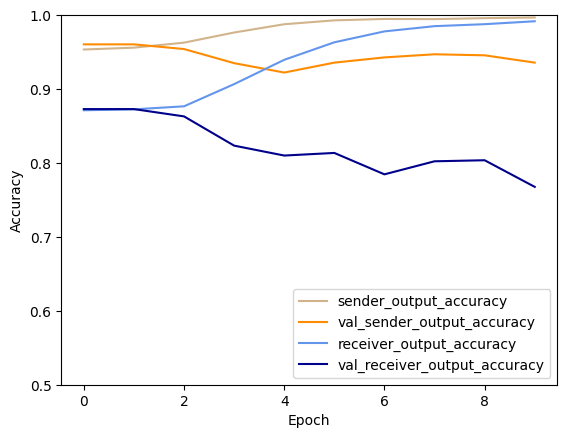

========== Test Evaluation ==========
86/86 - 2s - loss: 3.7773 - sender_output_loss: 1.3236 - receiver_output_loss: 2.4537 - sender_output_accuracy: 0.8862 - receiver_output_accuracy: 0.7344 - 2s/epoch - 21ms/step

========== Test Metrics ==========
86/86 [==============================] - 2s 18ms/step
---------- Sender Labels ----------
              precision    recall  f1-score   support

        True       0.92      0.96      0.94      2501
       False       0.17      0.08      0.11       240

    accuracy                           0.89      2741
   macro avg       0.54      0.52      0.52      2741
weighted avg       0.85      0.89      0.87      2741

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True       0.84      0.85      0.85      2310
       False       0.10      0.05      0.07       165
NOANNOTATION       0.09      0.11      0.10       266

    accuracy                           0.73      2741
   macro avg       0.3

In [142]:
EvaluateModel(context_lstm_model, [test_encoded_padded, test_prev_encoded_padded], [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']], context_lstm_history)

# LSTM + Power

In [143]:
def create_lstm_power_model(
        sequence_length: int = MAX_SEQUENCE_LEN,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        vocab_size: int = VOCAB_SIZE,
        lstm_size: int = LSTM_SIZE,
        dropout: float = DROPOUT_RATE,
        hidden_size = HIDDEN_LAYER_SIZE,
        learning_rate: float = LEARNING_RATE,
    ):

    message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input')
    power_diff_input = keras.layers.Input(shape=(1,), name='power_differential')

    lstm_output = pipe(
        message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.LSTM(lstm_size),
        keras.layers.Dropout(dropout)
    )

    lstm_power_ouput = pipe(
        [
            lstm_output,
            power_diff_input
        ],
        keras.layers.Concatenate(),
        keras.layers.Dense(hidden_size),
    )

    sender_output = keras.layers.Dense(2, activation='softmax', name="sender_output")(lstm_power_ouput)
    receiver_output = keras.layers.Dense(3, activation='softmax', name="receiver_output")(lstm_power_ouput)

    lstm_power_model = keras.Model(
        inputs=[message_input, power_diff_input],
        outputs=[sender_output, receiver_output]
    )

    lstm_power_model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )

    return lstm_power_model

In [144]:
lstm_power_model = create_lstm_power_model()
lstm_power_model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 current_message_input (Inp  [(None, 294)]                0         []                            
 utLayer)                                                                                         
                                                                                                  
 embedding_18 (Embedding)    (None, 294, 124)             620000    ['current_message_input[0][0]'
                                                                    ]                             
                                                                                                  
 lstm_5 (LSTM)               (None, 64)                   48384     ['embedding_18[0][0]']        
                                                                                           

In [145]:
lstm_power_history = context_lstm_model.fit(
    [train_encoded_padded, train_df['game_score_delta']],
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=([validation_encoded_padded, validation_df['game_score_delta']], [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]), 
    epochs=10
)

Epoch 1/10
411/411 [==============================] - 17s 36ms/step - loss: 0.3503 - sender_output_loss: 0.0798 - receiver_output_loss: 0.2706 - sender_output_accuracy: 0.9734 - receiver_output_accuracy: 0.9024 - val_loss: 0.9959 - val_sender_output_loss: 0.3053 - val_receiver_output_loss: 0.6907 - val_sender_output_accuracy: 0.9428 - val_receiver_output_accuracy: 0.8475
Epoch 2/10
411/411 [==============================] - 13s 32ms/step - loss: 0.2357 - sender_output_loss: 0.0515 - receiver_output_loss: 0.1842 - sender_output_accuracy: 0.9817 - receiver_output_accuracy: 0.9351 - val_loss: 1.2530 - val_sender_output_loss: 0.3769 - val_receiver_output_loss: 0.8761 - val_sender_output_accuracy: 0.9364 - val_receiver_output_accuracy: 0.8016
Epoch 3/10
411/411 [==============================] - 13s 32ms/step - loss: 0.1883 - sender_output_loss: 0.0382 - receiver_output_loss: 0.1501 - sender_output_accuracy: 0.9874 - receiver_output_accuracy: 0.9449 - val_loss: 1.3931 - val_sender_output_lo

========== Model Accuracy ==========


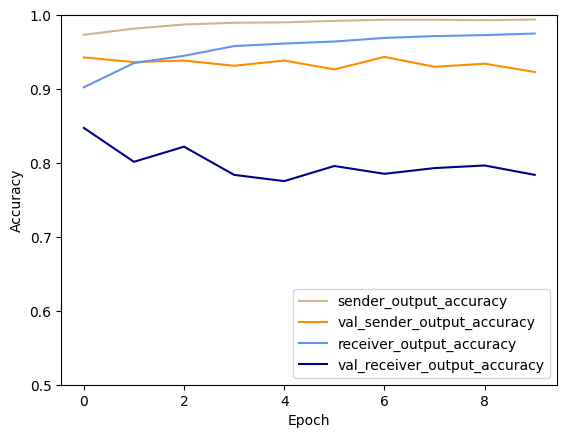

========== Test Evaluation ==========
86/86 - 2s - loss: 1.9627 - sender_output_loss: 0.7468 - receiver_output_loss: 1.2160 - sender_output_accuracy: 0.5002 - receiver_output_accuracy: 0.3630 - 2s/epoch - 26ms/step

========== Test Metrics ==========
86/86 [==============================] - 1s 9ms/step
---------- Sender Labels ----------
              precision    recall  f1-score   support

        True       0.90      0.51      0.65      2501
       False       0.07      0.38      0.12       240

    accuracy                           0.50      2741
   macro avg       0.48      0.44      0.38      2741
weighted avg       0.82      0.50      0.60      2741

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True       0.87      0.38      0.53      2310
       False       0.07      0.55      0.12       165
NOANNOTATION       0.08      0.12      0.10       266

    accuracy                           0.36      2741
   macro avg       0.34

In [146]:
EvaluateModel(lstm_power_model, [test_encoded_padded, test_df['game_score_delta']], [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']], lstm_power_history)

# Context LSTM + Power

In [147]:
def create_context_lstm_power_model(
        sequence_length: int = MAX_SEQUENCE_LEN,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        vocab_size: int = VOCAB_SIZE,
        lstm_size: int = LSTM_SIZE,
        dropout: float = DROPOUT_RATE,
        hidden_size = HIDDEN_LAYER_SIZE,
        learning_rate: float = LEARNING_RATE,
    ):

    current_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input')
    previous_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='previous_message_input')
    power_diff_input = keras.layers.Input(shape=(1,), name='power_differential')

    current_message_lstm = pipe(
        current_message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.LSTM(lstm_size),
        keras.layers.Dropout(dropout)
    )

    previous_message_lstm = pipe(
        previous_message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.LSTM(lstm_size),
        keras.layers.Dropout(dropout)
    )

    context_lstm_power_ouput = pipe(
        [
            current_message_lstm,
            previous_message_lstm,
            power_diff_input
        ],
        keras.layers.Concatenate(),
        keras.layers.Dense(hidden_size)
    )

    sender_output = keras.layers.Dense(2, activation='softmax', name="sender_output")(context_lstm_power_ouput)
    receiver_output = keras.layers.Dense(3, activation='softmax', name="receiver_output")(context_lstm_power_ouput)

    context_lstm_power_model = keras.Model(
        inputs=[current_message_input, previous_message_input, power_diff_input],
        outputs=[sender_output, receiver_output]
    )

    context_lstm_power_model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )

    return context_lstm_power_model

In [148]:
context_lstm_power_model = create_context_lstm_power_model()
context_lstm_power_model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 current_message_input (Inp  [(None, 294)]                0         []                            
 utLayer)                                                                                         
                                                                                                  
 previous_message_input (In  [(None, 294)]                0         []                            
 putLayer)                                                                                        
                                                                                                  
 embedding_19 (Embedding)    (None, 294, 124)             620000    ['current_message_input[0][0]'
                                                                    ]                      

In [150]:
context_lstm_power_history = context_lstm_power_model.fit(
    [train_encoded_padded, train_prev_encoded_padded, train_df['game_score_delta']],
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=([validation_encoded_padded, validation_prev_encoded_padded, validation_df['game_score_delta']], [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]), 
    epochs=10
)

Epoch 1/10
411/411 [==============================] - 34s 83ms/step - loss: 0.6427 - sender_output_loss: 0.1782 - receiver_output_loss: 0.4645 - sender_output_accuracy: 0.9551 - receiver_output_accuracy: 0.8726 - val_loss: 0.6323 - val_sender_output_loss: 0.1671 - val_receiver_output_loss: 0.4652 - val_sender_output_accuracy: 0.9597 - val_receiver_output_accuracy: 0.8729
Epoch 2/10
411/411 [==============================] - 22s 55ms/step - loss: 0.5602 - sender_output_loss: 0.1457 - receiver_output_loss: 0.4145 - sender_output_accuracy: 0.9565 - receiver_output_accuracy: 0.8724 - val_loss: 0.6961 - val_sender_output_loss: 0.1932 - val_receiver_output_loss: 0.5029 - val_sender_output_accuracy: 0.9583 - val_receiver_output_accuracy: 0.8722
Epoch 3/10
411/411 [==============================] - 21s 52ms/step - loss: 0.4223 - sender_output_loss: 0.0994 - receiver_output_loss: 0.3228 - sender_output_accuracy: 0.9660 - receiver_output_accuracy: 0.8859 - val_loss: 0.8202 - val_sender_output_lo

========== Model Accuracy ==========


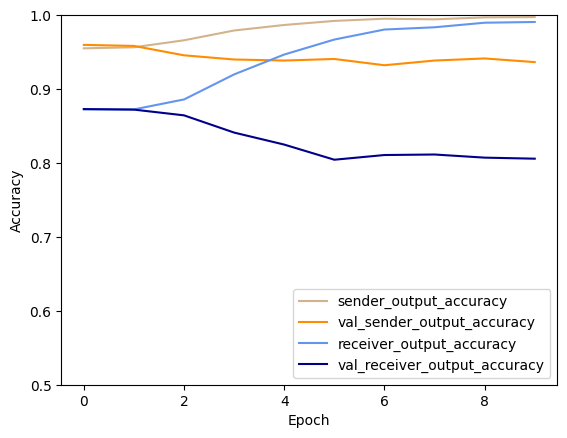

========== Test Evaluation ==========
86/86 - 2s - loss: 3.6726 - sender_output_loss: 1.2869 - receiver_output_loss: 2.3857 - sender_output_accuracy: 0.8887 - receiver_output_accuracy: 0.7775 - 2s/epoch - 23ms/step

========== Test Metrics ==========
86/86 [==============================] - 2s 19ms/step
---------- Sender Labels ----------
              precision    recall  f1-score   support

        True       0.92      0.96      0.94      2501
       False       0.21      0.10      0.14       240

    accuracy                           0.89      2741
   macro avg       0.57      0.53      0.54      2741
weighted avg       0.86      0.89      0.87      2741

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True       0.85      0.91      0.88      2310
       False       0.10      0.05      0.07       165
NOANNOTATION       0.10      0.06      0.08       266

    accuracy                           0.78      2741
   macro avg       0.3

In [151]:
EvaluateModel(context_lstm_power_model, [test_encoded_padded, test_prev_encoded_padded, test_df['game_score_delta']], [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']], context_lstm_power_history)